In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy import linalg
from scipy.stats import norm, multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import seed, rand, randn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
np.set_printoptions(suppress=True, precision=5)

In [4]:
μ = np.array([-20, 20.])
σ = np.array([10, 10.])
π = np.array([0.3, 0.7])
kv = np.arange(2)

In [5]:
def kdeg(x, X, h):
    """
    KDE under a gaussian kernel
    
    Parameters
    ----------
    x: array(eval, D)
    X: array(obs, D)
    h: float
    """
    N, D = X.shape
    nden, _ = x.shape # number of density points
    
    Xhat = X.reshape(D, 1, N)
    xhat = x.reshape(D, nden, 1)
    u = xhat - Xhat
    u = linalg.norm(u, ord=2, axis=0) ** 2 / (2 * h ** 2) # (N, nden)
    px = np.exp(-u).sum(axis=1) / (N * h * np.sqrt(2 * np.pi))
    return px

def scale_3d(ax, x_scale, y_scale, z_scale, factor=0.62):

    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=factor

    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)
    return short_proj

def style3d(ax, x_scale, y_scale, z_scale):
    plt.gca().patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.get_proj = scale_3d(ax, x_scale, y_scale, z_scale)

## Gibbs Sampling

In [6]:
def sample_step(xs, π, μ, σ):
    pz = norm(μ, σ).pdf(xs) * π
    pz = pz / pz.sum()
    zs = np.random.choice(kv, p=pz)
    xs = norm(μ[zs], σ[zs]).rvs()
    return xs, zs

In [7]:
def gibbs_sample(xs, zs, π, μ, σ, n_iterations):
    x_hist = np.zeros(n_iterations)
    z_hist = np.zeros(n_iterations)
    x_hist[0] = xs
    z_hist[0] = zs

    for s in range(1, n_iterations):
        pz = norm(μ, σ).pdf(xs) * π
        pz = pz / pz.sum()
        zs = np.random.choice(kv, p=pz)
        xs = norm(μ[zs], σ[zs]).rvs()

        x_hist[s] = xs
        z_hist[s] = zs
    
    return x_hist, z_hist

In [8]:
xs = 20
zs = 0

np.random.seed(3141)
n_iterations = 1000
x_hist, z_hist = gibbs_sample(xs, zs, π, μ, σ, n_iterations)

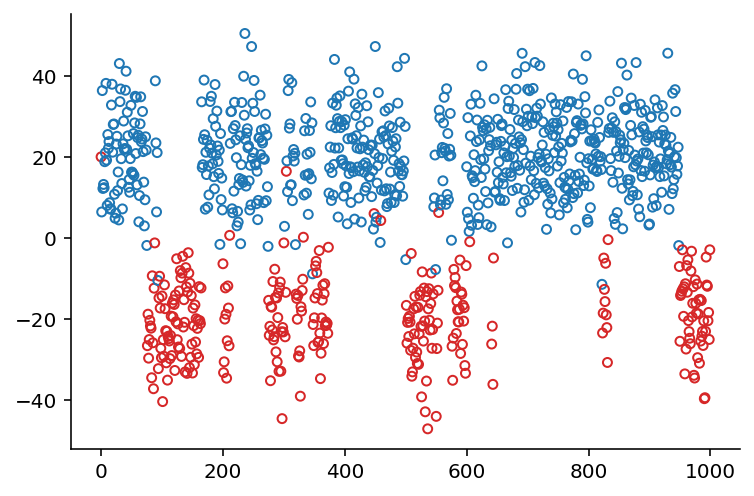

In [9]:
colors = ["tab:blue" if z else "tab:red" for z in z_hist]
plt.scatter(np.arange(n_iterations), x_hist, s=20, facecolors="none", edgecolors=colors)

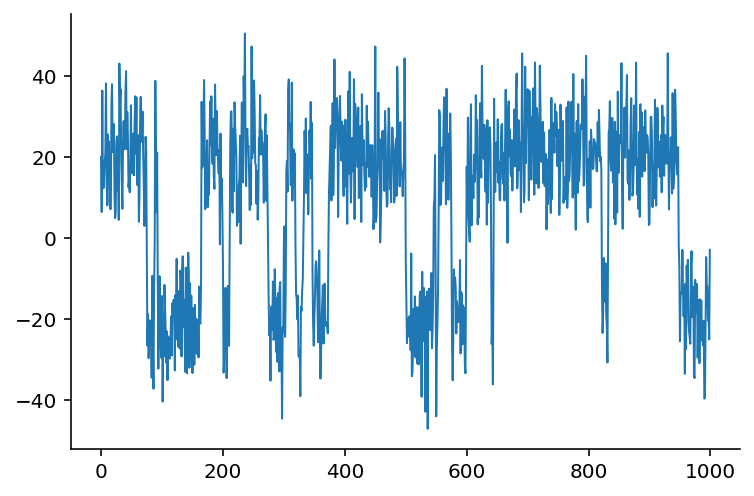

In [10]:
plt.plot(x_hist, linewidth=1)

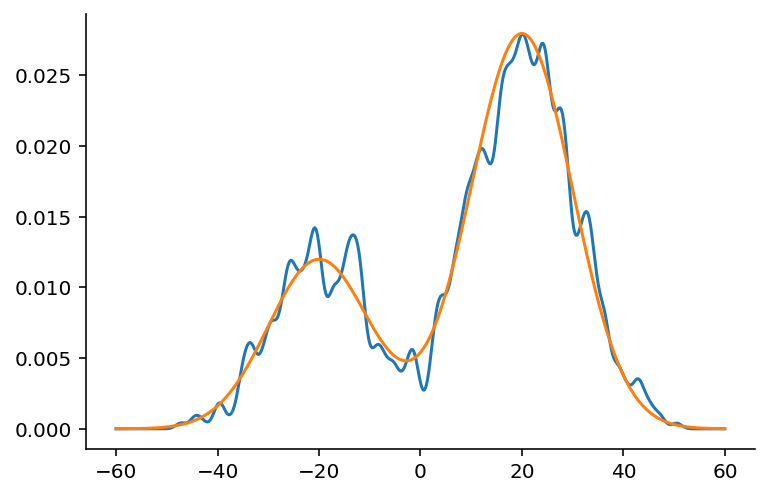

In [11]:
n_eval = 500
x_eval = np.linspace(-60, 60, n_eval)
kde_eval = kdeg(x_eval[:, None], x_hist[:, None], 1)
px = norm(μ, σ).pdf(x_eval[:, None]) * π
px = px.sum(axis=-1)

plt.plot(x_eval, kde_eval)
plt.plot(x_eval, px);

In [160]:
def scale_3d(ax, x_scale, y_scale, z_scale, factor=0.62):

    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=factor

    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)
    return short_proj

def style3d(ax, x_scale, y_scale, z_scale):
    plt.gca().patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.get_proj = scale_3d(ax, x_scale, y_scale, z_scale)

In [161]:
def plot_gmm_3d_trace(trace_hist, π, μ, σ, title, xmin, xmax, ax, h=1):
    n_eval = 500
    x_eval = np.linspace(xmin, xmax, n_eval)
    kde_eval = kdeg(x_eval[:, None], trace_hist[:, None], h)
    px = norm(μ, σ).pdf(x_eval[:, None]) * π
    px = px.sum(axis=-1)

    ax.plot(np.arange(n_iterations), trace_hist)
    ax.plot(np.zeros(n_eval), x_eval, px, c="tab:red", linewidth=2)
    ax.plot(np.zeros(n_eval), x_eval, kde_eval, c="tab:blue")

    ax.set_zlim(0, kde_eval.max() * 1.1)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Samples")

    ax.view_init(25, -30)
    ax.set_title(title)

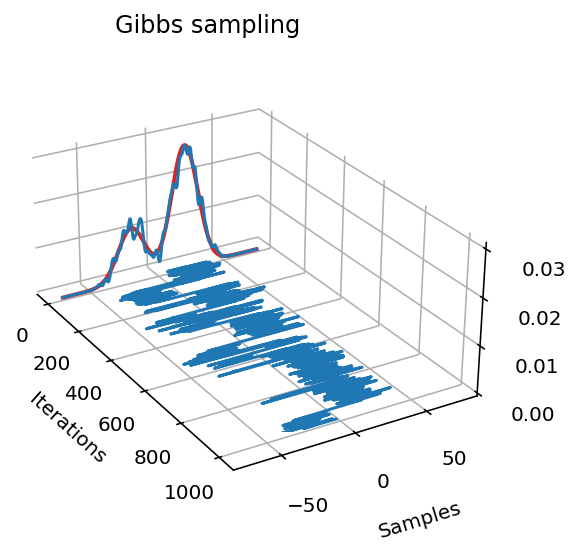

In [166]:
fig = plt.figure()
ax = plt.axes(projection="3d")
xmin = x_hist.min() * 1.5
xmax = x_hist.max() * 1.5
plot_gmm_3d_trace(x_hist, π, μ, σ, "Gibbs sampling", xmin, xmax, ax)
style3d(ax, 1.5, 1, 0.8)
plt.subplots_adjust(left=0.001, bottom=0.208, right=0.7)
#plt.savefig("/Users/gerardoduran/Desktop/gibbs-sampling.pdf", pad_inches=0, bbox_inches="tight")

In [163]:
!open /Users/gerardoduran/Desktop/gibbs-sampling.pdf

## Random-walk Metropolis

In [150]:
x0 = 20.0
n_iterations = 1000

In [151]:
def mh_sample(xs, τ, π, μ, σ, n_iterations):
    hist = np.zeros(n_iterations)
    hist[0] = xs

    for s in range(1, n_iterations):
        x_candidate = xs + τ * randn()
        
        p_candidate = (norm(μ, σ).pdf(x_candidate) * π).sum()
        p_curr = (norm(μ, σ).pdf(xs) * π).sum()
        
        α = p_candidate / p_curr
        A = min(1, α)
        u = rand()
        
        xs = xs if u >= A else x_candidate
        hist[s] = xs
        
    return hist

In [152]:
seed(314)
x_mh1 = mh_sample(x0, 1, π, μ, σ, n_iterations)
x_mh2 = mh_sample(x0, 8, π, μ, σ, n_iterations)
x_mh3 = mh_sample(x0, 500, π, μ, σ, n_iterations)

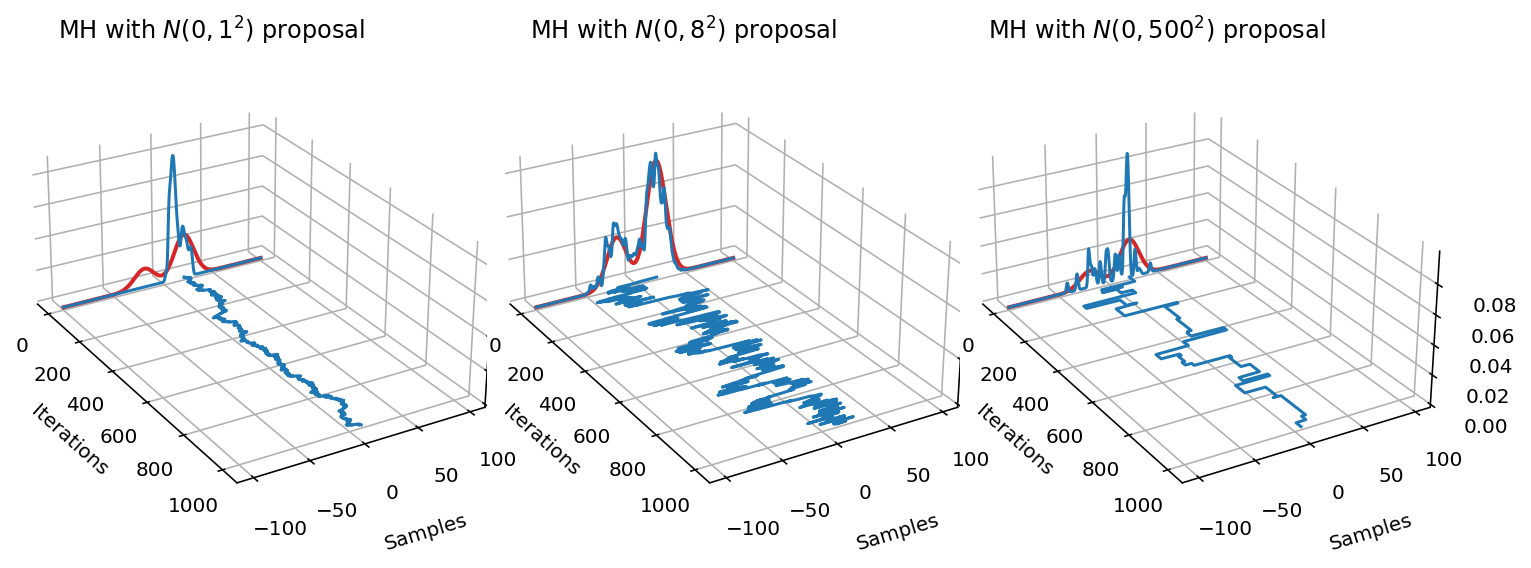

In [153]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1,3,1,projection="3d")
plot_gmm_3d_trace(x_mh1, π, μ, σ, "MH with $N(0,1^2)$ proposal", -100, 100, ax)
style3d(ax, 1.5,1,0.8)

ax = fig.add_subplot(1,3,2,projection="3d")
plot_gmm_3d_trace(x_mh2, π, μ, σ, "MH with $N(0,8^2)$ proposal", -100, 100, ax)
style3d(ax, 1.5,1,0.8)


ax = fig.add_subplot(1,3,3,projection="3d")
plot_gmm_3d_trace(x_mh3, π, μ, σ, "MH with $N(0,500^2)$ proposal", -100, 100, ax)
style3d(ax, 1.5,1,0.8)

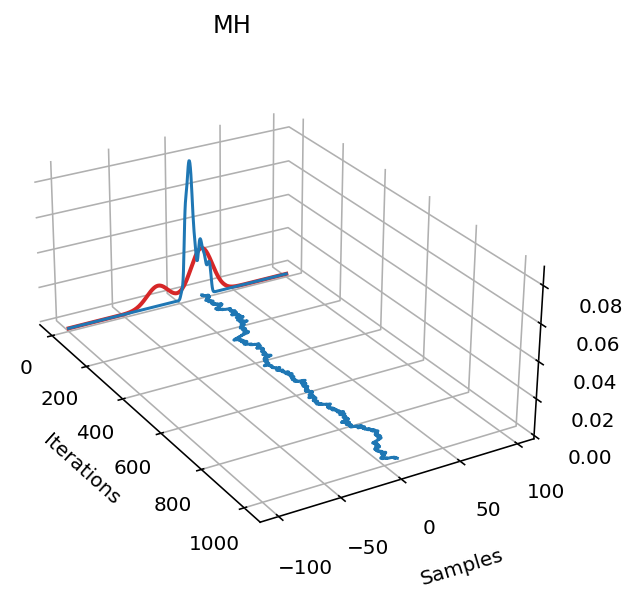

In [155]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plot_gmm_3d_trace(x_mh1, π, μ, σ, "MH", -100, 100, ax)
style3d(ax, 1.5,1,0.8)

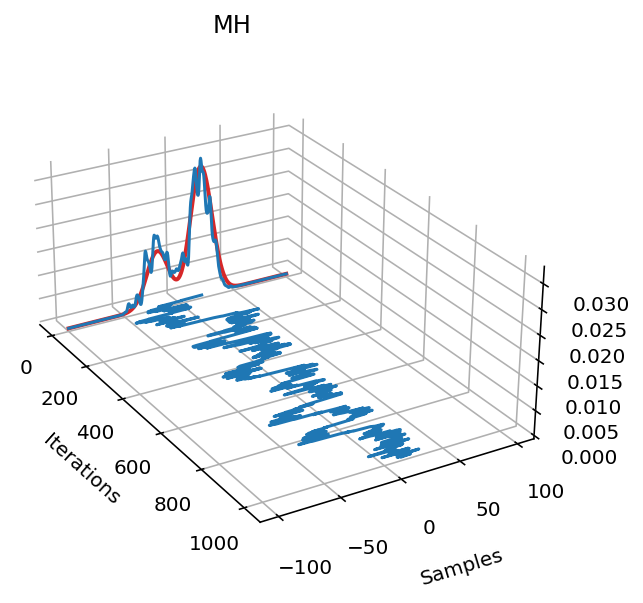

In [156]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plot_gmm_3d_trace(x_mh2, π, μ, σ, "MH", -100, 100, ax)
style3d(ax, 1.5,1,0.8)

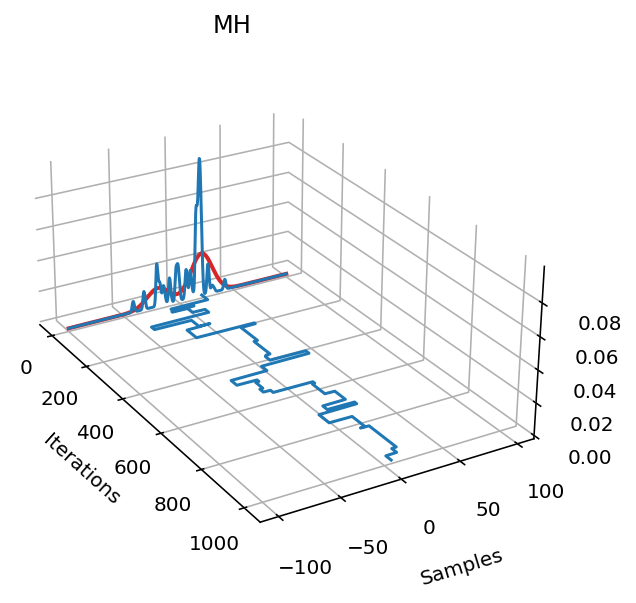

In [157]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plot_gmm_3d_trace(x_mh3, π, μ, σ, "MH", -100, 100, ax)
style3d(ax, 1.5,1,0.8)

## Autocorrelation plots

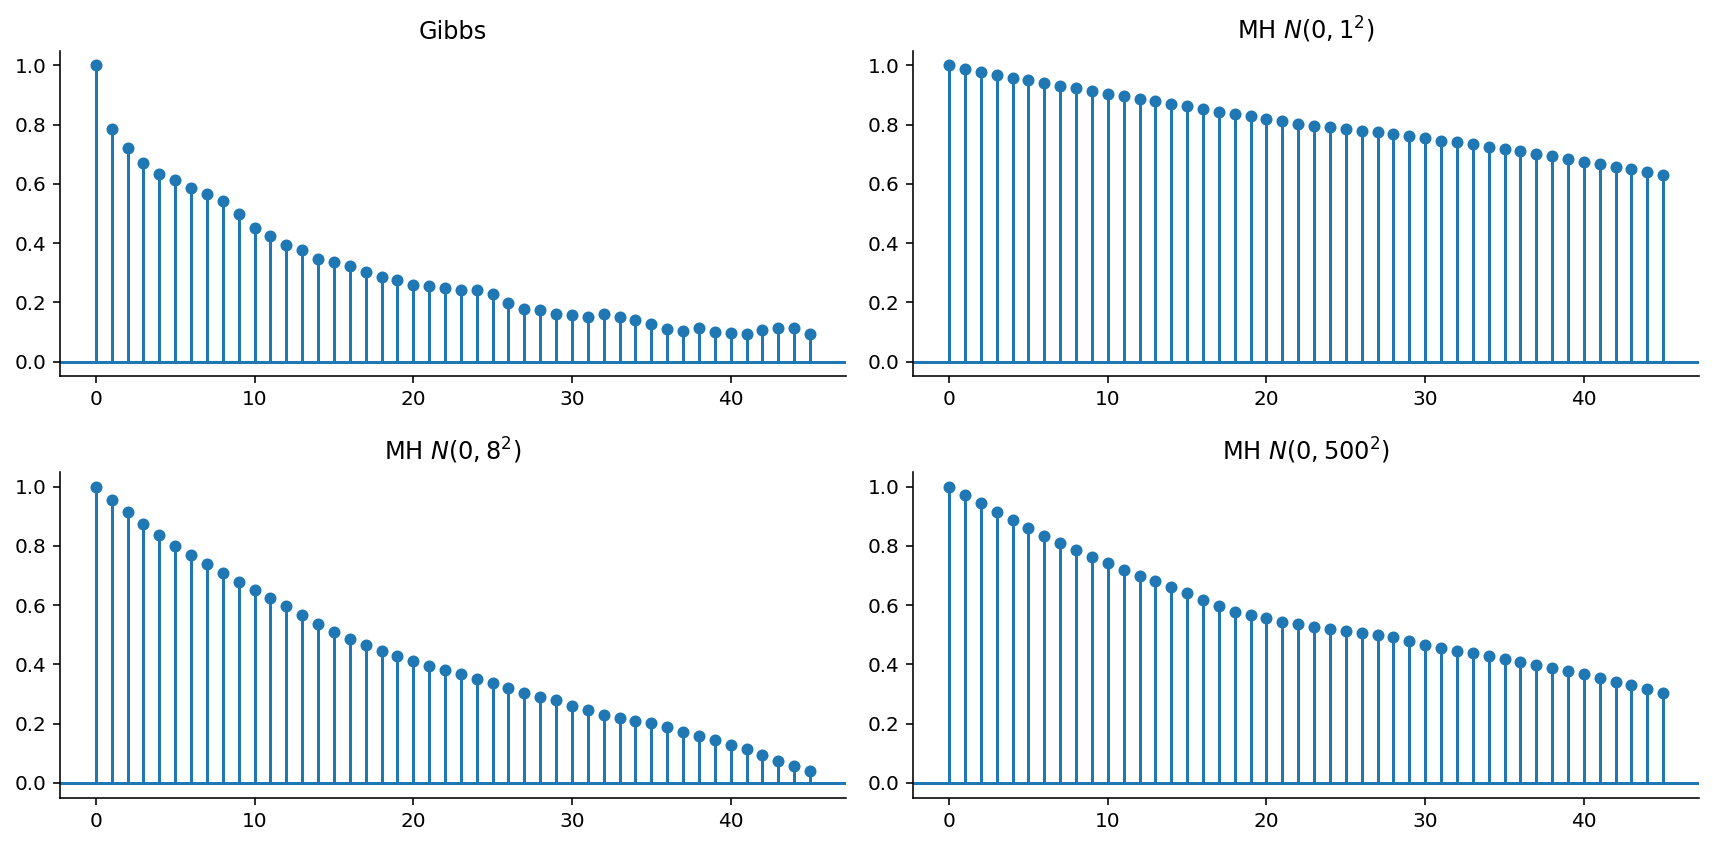

In [267]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
sm.graphics.tsa.plot_acf(x_hist, lags=45, alpha=None, ax=ax[0], title="Gibbs")
sm.graphics.tsa.plot_acf(x_mh1, lags=45, alpha=None, ax=ax[1], title=r"MH $N(0,1^2)$")
sm.graphics.tsa.plot_acf(x_mh2, lags=45, alpha=None, ax=ax[2], title=r"MH $N(0,8^2)$")
sm.graphics.tsa.plot_acf(x_mh3, lags=45, alpha=None, ax=ax[3], title=r"MH $N(0,500^2)$")
plt.tight_layout()